In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/pre_BTC-USD.csv')
df = df.rename(columns={'Close': 'Price'})
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Date,Open,High,Low,Price,Adj Close,Volume
0,2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
1,2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2,2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
3,2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
4,2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2285 non-null   datetime64[ns]
 1   Open       2285 non-null   float64       
 2   High       2285 non-null   float64       
 3   Low        2285 non-null   float64       
 4   Price      2285 non-null   float64       
 5   Adj Close  2285 non-null   float64       
 6   Volume     2285 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 125.1 KB


In [4]:
# Thiết lập index
df1=df.reset_index()['Price']


In [5]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# Chia train test
train_size= int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i + time_step)]
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)


In [8]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100 _8_2
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
combined_data = np.concatenate((train_data[-time_step:], test_data))
X_test, y_test = create_dataset(combined_data, time_step)

# Reshape dữ liệu cho phù hợp với mạng GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
24/24 [==============================] - 4s 66ms/step - loss: 0.0203
Epoch 2/100
24/24 [==============================] - 2s 89ms/step - loss: 0.0014
Epoch 3/100
24/24 [==============================] - 2s 96ms/step - loss: 5.2585e-04
Epoch 4/100
24/24 [==============================] - 2s 103ms/step - loss: 4.4834e-04
Epoch 5/100
24/24 [==============================] - 2s 66ms/step - loss: 4.2065e-04
Epoch 6/100
24/24 [==============================] - 1s 62ms/step - loss: 4.3242e-04
Epoch 7/100
24/24 [==============================] - 1s 48ms/step - loss: 4.0278e-04
Epoch 8/100
24/24 [==============================] - 1s 49ms/step - loss: 3.8752e-04
Epoch 9/100
24/24 [==============================] - 1s 51ms/step - loss: 3.8039e-04
Epoch 10/100
24/24 [==============================] - 1s 50ms/step - loss: 3.7961e-04
Epoch 11/100
24/24 [==============================] - 1s 50ms/step - loss: 3.6331e-04
Epoch 12/100
24/24 [==============================] - 1s 52ms/step - l

In [11]:
# Dự báo dữ liệu test và train
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

22/22 [==============================] - 0s 12ms/step


In [12]:
# Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [13]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

i = 0
while(i < 90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])  # Lấy từng ngày từ ngày thứ 2 trở đi
        x_input = x_input.reshape(1, time_step, 1)  # Reshape lại để phù hợp với input của mạng
        yhat = model.predict(x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
        temp_input.extend(yhat[0].tolist())  # Thêm dự đoán vào danh sách temp_input
        temp_input = temp_input[1:]  # Loại bỏ ngày đầu tiên
        lst_output.extend(yhat.tolist())  # Lưu dự đoán vào mảng lst_output
        i += 1
    else:
        x_input = x_input.reshape(1, time_step, 1)  # Reshape lại để phù hợp với input của mạng
        yhat = model.predict(x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
        temp_input.extend(yhat[0].tolist())  # Thêm dự đoán vào danh sách temp_input
        lst_output.extend(yhat.tolist())  # Lưu dự đoán vào mảng lst_output
        i += 1

# In ra dự đoán cho 90 ngày tiếp theo
print("Dự đoán giá cho 90 ngày tiếp theo:")
print(lst_output)

Dự đoán giá cho 90 ngày tiếp theo:
[[0.9008508324623108], [0.881278395652771], [0.8613240718841553], [0.8411193490028381], [0.8209267854690552], [0.8008967638015747], [0.7811381816864014], [0.7617332339286804], [0.7427480220794678], [0.7242353558540344], [0.7062370777130127], [0.6887859106063843], [0.6719056367874146], [0.6556127667427063], [0.6399174332618713], [0.6248233318328857], [0.6103289723396301], [0.5964284539222717], [0.5831120014190674], [0.5703659057617188], [0.5581744909286499], [0.5465193390846252], [0.5353803038597107], [0.5247359871864319], [0.5145641565322876], [0.5048422813415527], [0.49554726481437683], [0.4866565465927124], [0.47814762592315674], [0.4699983596801758], [0.4621877074241638], [0.4546951651573181], [0.4475012421607971], [0.44058719277381897], [0.43393558263778687], [0.42752957344055176], [0.42135360836982727], [0.41539302468299866], [0.4096341133117676], [0.40406426787376404], [0.398671418428421], [0.39344456791877747], [0.38837364315986633], [0.3834491

In [14]:
predict_future_30 = lst_output[:30]
predict_future_60 = lst_output[30:60]
predict_future_90 = lst_output[60:]


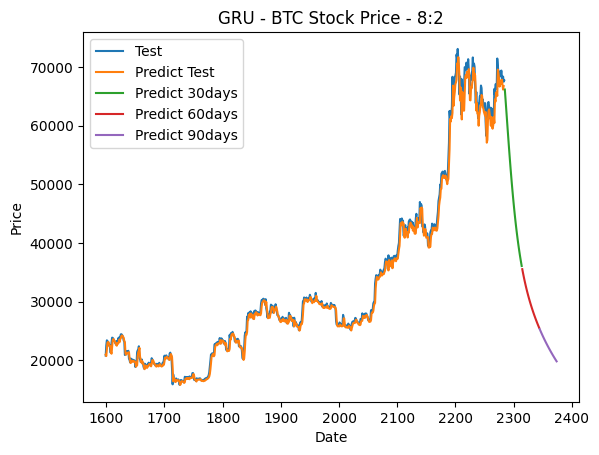

In [15]:
#Vẽ hình
# train_data_index = pd.RangeIndex(start=0, stop=len(train_data), step=1)
# plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_test_index = pd.RangeIndex(start=train_size, stop=train_size+len(y_pred), step=1)
plt.plot(predicted_test_index, y_pred)

predict_future_30_index = pd.RangeIndex(start=test_data_index[-1]+1, stop=test_data_index[-1]+31, step=1)
plt.plot(predict_future_30_index, scaler.inverse_transform(predict_future_30))

predict_future_60_index = pd.RangeIndex(start=test_data_index[-1]+31, stop=test_data_index[-1]+61, step=1)
plt.plot(predict_future_60_index, scaler.inverse_transform(predict_future_60))

predict_future_90_index = pd.RangeIndex(start=test_data_index[-1]+61, stop=test_data_index[-1]+91, step=1)
plt.plot(predict_future_90_index, scaler.inverse_transform(predict_future_90))

plt.title('GRU - BTC Stock Price - 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Test','Predict Test','Predict 30days','Predict 60days','Predict 90days'])
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 32630.536768342583
Mean Absolute Percentage Error (MAPE): 7820766.856748024
Root Mean Square Error (RMSE): 35951.35358180854
